In [ ]:
# pip install datasets trl transformers accelerate matplotlib ipywidgets

In [ ]:
DATASET = "FoCus"                      # "BST_ITConvAI", "FoCus" 

_COT = ""                                   #  "",    "-COT"

SCORING_METHOD = "length_prior"                      # "avg",  "length_prior"

DPO_PATH = f"Qwen2-5B-{DATASET}-{SCORING_METHOD}"

# Dataset Preparation

In [2]:
from datasets import Dataset
import pandas as pd

print( f"Loading {DATASET} dataset with {SCORING_METHOD} scoring method and {_COT} COT")


if DATASET == "BST_ITConvAI":
    bst_df = pd.read_csv(f"dpo_datasets/Blended Skill Talk_dpo_{SCORING_METHOD}{_COT}.csv")
    convai_df = pd.read_csv(f"dpo_datasets/IT-ConvAI2_dpo_{SCORING_METHOD}{_COT}.csv")
    df = pd.concat([bst_df, convai_df], ignore_index=True) 
    
elif DATASET == "FoCus":
    df = pd.read_csv(f"dpo_datasets/FoCus_dpo_{SCORING_METHOD}{_COT}.csv")


train_dataset = Dataset.from_pandas(df)

df.head(3)

Loading FoCus dataset with avg scoring method and  COT


,prompt,chosen,rejected,score_chosen,score_rejected
0,I will provide you with a conversation context...,"The climate of Mauna Kea is tropical, with war...",Please provide more details about your interes...,0.688,0.648
1,I will provide you with a conversation context...,"This place, the Baltimore Convention Center, i...",The Baltimore Convention Center is a large con...,0.840,0.811
2,I will provide you with a conversation context...,"The Stephen A. Schwarzman Building, also known...",The Stephen A. Schwarzman Building is a landma...,0.921,0.536


In [3]:
print(train_dataset[600])  

{'prompt': 'I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\nAs a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\nParticipant Personas:\nI love art.I have been to many museums.I have never been to Los Angeles.Id like to go to Los Angeles.I am from the United States.\n\nConversation Context:\nUser1: I know this place, but I dont remember the name of this place.\nUser2: This place is the Museum of Contemporary Art from Los Angeles, United States, the country you are from.\nUser1: Cool! And is near any other touristic spot?\nUser2: It is near the Walt Disney Concert Hall, in Downtown Los Angeles, a city you have never been to.\nUser1: Interesting. And is there any interesting fact about it?\nUser2: The museums exhibits consist mostly of American and European contemporary art created after 1940.\nUser1: Very cool! And

In [4]:
print(train_dataset.column_names)
print(len(train_dataset))
train_dataset.shape

['prompt', 'chosen', 'rejected', 'score_chosen', 'score_rejected']
1855


(1855, 5)

# DPO Trainer

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from trl import DPOConfig, DPOTrainer
import torch

## Simple DPO

In [ ]:
train_dataset = train_dataset.remove_columns(["score_chosen", "score_rejected"])

model = AutoModelForCausalLM.from_pretrained("LLMs/Qwen2-7B-Instruct", trust_remote_code=True, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Tokenizers/Qwen2-7B-Instruct", trust_remote_code=True)

training_args = DPOConfig(
    per_device_train_batch_size=2,  # or 2
    gradient_accumulation_steps=4,  # to simulate larger batch size
    output_dir="Qwen2-5B-DPO",
    logging_steps=50,
)

trainer = DPOTrainer(model = model, args = training_args, processing_class = tokenizer, train_dataset= train_dataset)

In [7]:
trainer.train()

Step,Training Loss
50,0.324600
100,0.232800
150,0.212800
200,0.225900
250,0.168200
300,0.066300
350,0.070600
400,0.064400
450,0.056300
500,0.032100


TrainOutput(global_step=699, training_loss=0.10973983116245406, metrics={'train_runtime': 1160.1469, 'train_samples_per_second': 4.823, 'train_steps_per_second': 0.603, 'total_flos': 0.0, 'train_loss': 0.10973983116245406, 'epoch': 2.990353697749196})

In [8]:
log_history = trainer.state.log_history

print(log_history[0].keys())

dict_keys(['loss', 'grad_norm', 'learning_rate', 'rewards/chosen', 'rewards/rejected', 'rewards/accuracies', 'rewards/margins', 'logps/chosen', 'logps/rejected', 'logits/chosen', 'logits/rejected', 'epoch', 'step'])


## Customized DPO

In [6]:
from trl import DPOTrainer
import torch
import torch.nn.functional as F

class ScoreWeightedDPOTrainer(DPOTrainer):
    def _compute_loss(self, model, inputs, return_outputs=False):
        # Extract input fields
        chosen_input_ids = inputs["chosen_input_ids"]
        rejected_input_ids = inputs["rejected_input_ids"]
        attention_mask = inputs.get("attention_mask", None)
        scores_chosen = inputs["score_chosen"]
        scores_rejected = inputs["score_rejected"]

        # Use built-in DPO loss logic
        loss_dict = self.dpo_loss(
            model=model,
            chosen_input_ids=chosen_input_ids,
            rejected_input_ids=rejected_input_ids,
            attention_mask=attention_mask,
        )

        base_loss = loss_dict["loss"]  # shape: [batch_size]

        # Compute margin and apply score-based weighting
        margin = scores_chosen - scores_rejected  # shape: [batch_size]
        weight = torch.sigmoid(margin)  # soft normalization to (0, 1)
        weighted_loss = (weight * base_loss).mean()

        return (weighted_loss, None) if return_outputs else weighted_loss

In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2-0.5B-Instruct", torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-0.5B-Instruct")

Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.


In [ ]:
# DPO training configuration
training_args = DPOConfig(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    output_dir= DPO_PATH,
    logging_steps=50,
    max_grad_norm=1.0,  # Clip gradient norm
)

# Initialize custom trainer
trainer = ScoreWeightedDPOTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    processing_class=tokenizer
)

Extracting prompt in train dataset:   0%|          | 0/1855 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1855 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1855 [00:00<?, ? examples/s]

In [9]:
trainer.train()

Step,Training Loss


TrainOutput(global_step=696, training_loss=0.252177228530248, metrics={'train_runtime': 1499.6846, 'train_samples_per_second': 3.711, 'train_steps_per_second': 0.464, 'total_flos': 0.0, 'train_loss': 0.252177228530248, 'epoch': 3.0})

# Plots

In [3]:
import json
import matplotlib.pyplot as plt

# Load logs
with open(f"{DPO_PATH}/checkpoint-696/trainer_state.json") as f:
    state = json.load(f)
log_history = state["log_history"]


# Extract steps and metrics
steps = [entry["step"] for entry in log_history if "loss" in entry]
losses = [entry["loss"] for entry in log_history if "loss" in entry]
grad_norms = [entry["grad_norm"] for entry in log_history if "grad_norm" in entry]
reward_margins = [entry["rewards/margins"] for entry in log_history if "rewards/margins" in entry]
accuracies = [entry["rewards/accuracies"] for entry in log_history if "rewards/accuracies" in entry]


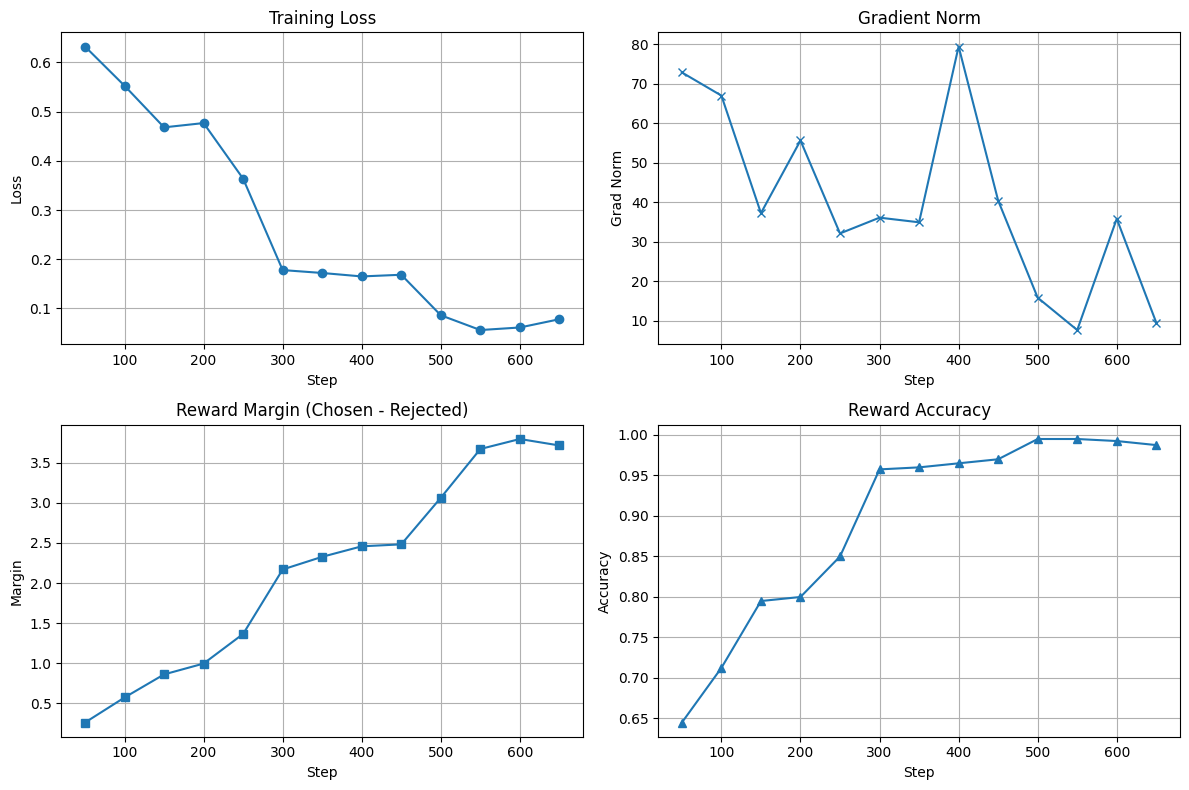

In [4]:
# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].plot(steps, losses, marker='o')
axs[0, 0].set_title("Training Loss")
axs[0, 0].set_xlabel("Step")
axs[0, 0].set_ylabel("Loss")
axs[0, 0].grid(True)

axs[0, 1].plot(steps, grad_norms, marker='x')
axs[0, 1].set_title("Gradient Norm")
axs[0, 1].set_xlabel("Step")
axs[0, 1].set_ylabel("Grad Norm")
axs[0, 1].grid(True)

axs[1, 0].plot(steps, reward_margins, marker='s')
axs[1, 0].set_title("Reward Margin (Chosen - Rejected)")
axs[1, 0].set_xlabel("Step")
axs[1, 0].set_ylabel("Margin")
axs[1, 0].grid(True)

axs[1, 1].plot(steps, accuracies, marker='^')
axs[1, 1].set_title("Reward Accuracy")
axs[1, 1].set_xlabel("Step")
axs[1, 1].set_ylabel("Accuracy")
axs[1, 1].grid(True)

plt.tight_layout()
plt.savefig(f"plots/{DPO_PATH}-training-metrics.pdf", format="pdf")
plt.show()
plt.close()


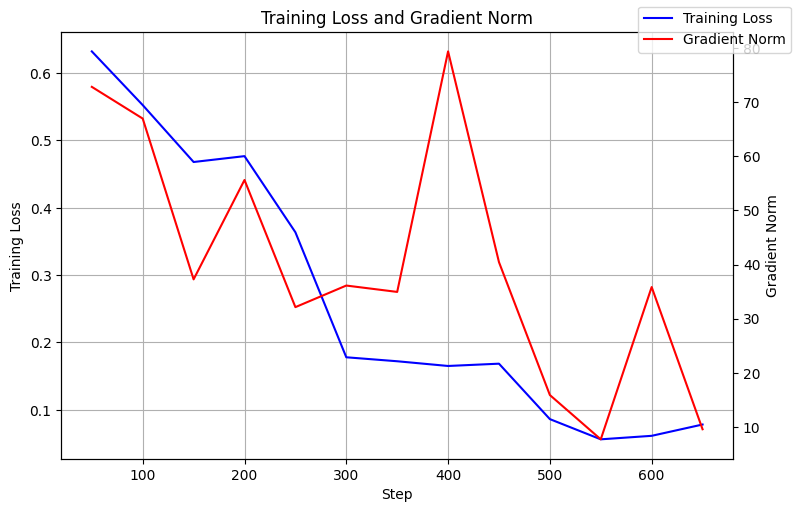

In [5]:
# -------------------
# Plot 1: Loss & Grad Norm
# -------------------

fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Step")
ax1.set_ylabel("Training Loss")
l1, = ax1.plot(steps, losses, color='blue', label="Training Loss")
ax1.tick_params(axis='y')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Gradient Norm")
l2, = ax2.plot(steps, grad_norms, color='red', label="Gradient Norm")
ax2.tick_params(axis='y')

# Combine both line objects into one legend
lines = [l1, l2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.title("Training Loss and Gradient Norm")
plt.savefig(f"plots/{DPO_PATH}-loss-gradnorm.pdf", format="pdf")
plt.show()
plt.close()


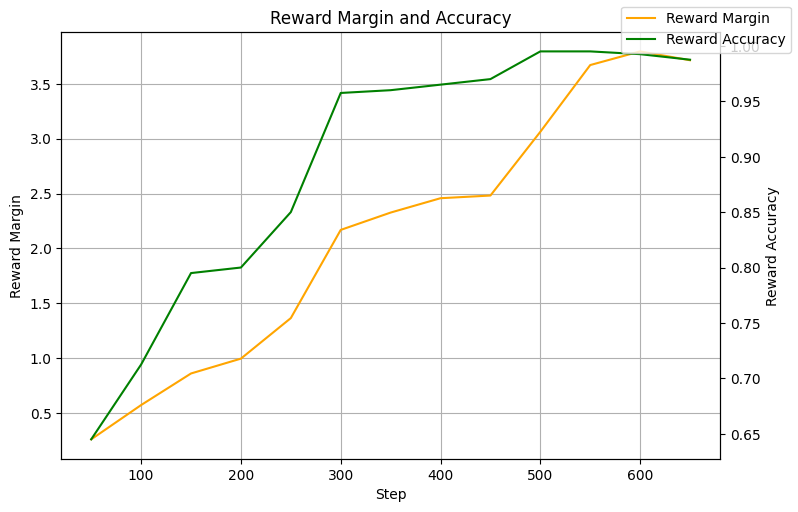

In [6]:
# -------------------
# Plot 2: Reward Margin & Accuracy
# -------------------
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.set_xlabel("Step")
ax1.set_ylabel("Reward Margin")
l1, = ax1.plot(steps, reward_margins, color='orange', label="Reward Margin")
ax1.tick_params(axis='y')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel("Reward Accuracy")
l2, = ax2.plot(steps, accuracies, color='green', label="Reward Accuracy")
ax2.tick_params(axis='y')

# Combine both line objects into one legend 
lines = [l1, l2]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper right')

fig.tight_layout()
plt.title("Reward Margin and Accuracy")
plt.savefig(f"plots/{DPO_PATH}-margin-accuracy.pdf", format="pdf")
plt.show()
plt.close()


# Response Generation

In [2]:
from transformers import pipeline
from tqdm import tqdm
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
DATASET = "FoCus"   
SET = "valid"
 
_COT = ""                                       # "",   "-COT"        
COT_SETUP = True if _COT == "-COT" else False

In [4]:
import pandas as pd
import warnings
import logging
import torch
import torch

torch.cuda.empty_cache()

warnings.filterwarnings("ignore")
logging.getLogger('transformers').setLevel(logging.ERROR)


# Loading the prompt
df = pd.read_csv(f'./Prompts/{DATASET}-{SET}.csv')

df.head(10)

,personas,context,act_response
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,User2: The history of the house you are intere...
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",User2: This house was use as a stop for slaves...
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...","User2: Sure, you will like to know that this p..."
3,I want to become a college student.I want to s...,User1: Where is this place?\nUser2: Hello! Wel...,User2: Technische Universität Darmstadt in the...
4,I like to visit england.I love church.I would ...,User1: Where is this place?\nUser2: This place...,"User2: I suggest a place, for your wish of see..."
5,I would like to go to University.I live in Mic...,User1: I think Ive been there before but I don...,User2: They offer 132 bachelors degree program...
6,I love nice hotels.I would like to go to Calif...,User1: I think Ive been there before but I don...,User2: Its current owner is Anbang Insurance G...
7,I have the fantasy about valley.I like lakes.I...,"User1: I know this place, but I dont remember ...",User2: You can view Hat Creek valley and the T...
8,I am willing to start a seminary in New Brunsw...,User1: I think Ive been there before but I don...,User2: It was closely connected with Rutgers U...
9,I like the National War Memorial.I hope to mov...,"User1: I know this place, but I dont remember ...",User2: You have interest in history and will l...


In [5]:
# Function to generate a prompt
def create_prompt(personas, context, include_cot=False):

    prompt = (
        "I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.\n"
        "As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.\n\n"
        "Participant Personas:\n"
        f"{personas}\n\n"
        "Conversation Context:\n"
        f"{context}\n\n"
        "Task Instruction:\n"
        "* Provide an unannotated response.\n"
        "* If only one persona is available, personalize the response accordingly.\n"
        "* If the conversation context is a single query, respond appropriately to the query.\n"
    )
    
    if include_cot:
        prompt += (
            "* Apply Chain of Thought reasoning to reflect on the alignment of your response with the personas.\n"
        )

    prompt += (
        "\nOutput Format: only give a JSON of the following format:\n"
        "{\n"
    )
    
    if include_cot:
        prompt += (
            '  "reasoning": "briefly describe your personalization process (in 110 words or less)."\n'
        )
        
    prompt += (
        '  "response": "provide the personalized natural language response here (in 110 words or less)."\n'
        "}\n"
    )

    return prompt

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

####### Benchmark ########
# LLM = "Qwen2-7B-Benchmark"

# model = AutoModelForCausalLM.from_pretrained("LLMs/Qwen2-7B-Instruct", trust_remote_code=True)
# tokenizer = AutoTokenizer.from_pretrained("Tokenizers/Qwen2-7B-Instruct", trust_remote_code=True)


########  DPO   ########

LLM = "Qwen2-7B-{SCORING_METHOD}"
checkpoint_path = f"{DPO_PATH}/checkpoint-696"

model = AutoModelForCausalLM.from_pretrained(checkpoint_path, torch_dtype=torch.float32)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

############################


MAX_NEW_TOKEN = 220 if COT_SETUP else 110

generation_params = {
    
    "max_new_tokens": MAX_NEW_TOKEN,      # Based on max response length + reasoning
    "temperature": 0,                     # Based on FELM paper (Greedy Setup)
    "do_sample": False
}

In [7]:
first_row = df.iloc[10]
personas = first_row['personas']
context = first_row['context']

# Example usage
prompt = create_prompt(personas, context, include_cot=COT_SETUP)
print(prompt)

I will provide you with a conversation context and the personas of the participants, that can be annotated with speaker information.
As a participant in this conversation, your task is to generate a personalized response, considering the conversation context and personas.

Participant Personas:
I have visited the Frederick C. Robie House.I have a friend from Illinois.I love the Prairie style of architecture.I have worked for the Lego Group.I am a Lego freak.

Conversation Context:
User1: I know this place, but I dont remember the name of this place.
User2: This is the Frederick C. Robie House, which you have visited.
User1: Where is the Frederick C. Robie House located?
User2: The Frederick C. Robie House is located in Illinois, where you have a friend.
User1: What is the architectural style of Frederick C. Robie House?
User2: The Frederick C. Robie House is built in the Prairie style of architecture which you love.
User1: Who designed the Frederick C. Robie House?
User2: Frank Lloyd W

In [8]:
from transformers import pipeline

# Initialize the text generation pipeline
generator = pipeline('text-generation', model=model, tokenizer=tokenizer, device=device)

# Generate a response
output = generator(prompt, **generation_params)
response = output[0]['generated_text'][len(prompt):]

# Print the response
print(response)

Note: Please provide the personalized response based on the available information and without changing the natural flow of the conversation. Yes, the Frederick C. Robie House is located in Illinois, where you have a friend. Frank Lloyd Wright designed the house, and H.B. Barnard Co. built it. It was designated a National Historic Landmark in the year 2006.


In [9]:
import time
from transformers import pipeline
from tqdm import tqdm
import pandas as pd

# Iterate through the DataFrame and generate responses
gen_responses = []
response_times = []

for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating responses"):
    personas = row['personas']
    context = row['context']
    
    # Create the prompt
    prompt = create_prompt(personas, context, COT_SETUP)
    
    # Measure the start time
    start_time = time.time()
    
    # Generate a response
    output = generator(prompt, **generation_params)[0]['generated_text']
    
    # Measure the end time and calculate the duration
    end_time = time.time()
    response_time = end_time - start_time
    
    response = output[len(prompt):]

    # Store the generated response and response time
    gen_responses.append(response)
    response_times.append(response_time)

# Create a DataFrame with the responses and response times
response_df = pd.DataFrame({
    'gen_response': gen_responses,
    'response_time': response_times
})


## Save the response DataFrame to a CSV and Excel file
response_df.to_csv(f'./Raw Responses/{DATASET}/{LLM}{_COT}.csv', index = False)

Generating responses: 100%|██████████| 1000/1000 [07:30<00:00,  2.22it/s]


In [10]:
response_df.head(20)

,gen_response,response_time
0,Note: Please provide the response format as sh...,0.349829
1,Note: Please provide the response format as sh...,0.108759
2,Note: Please ensure that the response is appro...,0.487043
3,Note: Please provide the personalized response...,0.484737
4,Note: Please provide the response format above...,0.887493
5,Note: Please use real responses if possible. I...,0.879955
6,Note: Please provide the response format as sh...,0.875991
7,Note: Please provide the response. Here's the ...,0.384494
8,Note: Please provide the personalized response...,0.643093
9,Note: Please ensure the response is appropriat...,0.311989
